In [32]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# Step 1: Load preprocessed data
train_data = pd.read_csv('preprocessed_train.csv')
test_data = pd.read_csv('preprocessed_test.csv')

# Step 2: Strip whitespace from column names
train_data.columns = train_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

# Step 3: Remove non-numeric or irrelevant columns
columns_to_remove = ['Breakfast Time', 'Lunch Time', 'CGM Data', 'Race', 'Viome']
train_data = train_data.drop(columns=columns_to_remove, errors='ignore')
test_data = test_data.drop(columns=columns_to_remove, errors='ignore')

# Step 4: Align train and test data columns
# Ensure train and test have the same feature columns
common_columns = [col for col in train_data.columns if col in test_data.columns]
train_data = train_data[common_columns + ['Lunch Calories']]  # Add target column back to train
test_data = test_data[common_columns]  # Test does not have 'Lunch Calories'

# Step 5: Define Dataset class for PyTorch
class MultimodalDataset(Dataset):
    def __init__(self, data, label_column=None):
        """
        Initialize the dataset with numeric data and optional label column.
        If label_column is None, this dataset is used for inference.
        """
        if label_column:
            self.labels = torch.tensor(data[label_column].values, dtype=torch.float32)
            self.features = torch.tensor(data.drop(columns=[label_column]).values, dtype=torch.float32)
        else:
            self.labels = None
            self.features = torch.tensor(data.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]
        return self.features[idx]

# Step 6: Prepare DataLoaders
label_column = 'Lunch Calories'

# Training data includes labels
train_dataset = MultimodalDataset(train_data, label_column=label_column)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Testing data excludes labels
test_dataset = MultimodalDataset(test_data, label_column=None)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 7: Verify DataLoader
print("Training Dataset Size:", len(train_loader.dataset))
print("Testing Dataset Size:", len(test_loader.dataset))

# Example: Iterate through the Training DataLoader
for batch_idx, (features, labels) in enumerate(train_loader):
    print(f"Training Batch {batch_idx + 1}")
    print("Features:", features)
    print("Labels:", labels)
    break

# Example: Iterate through the Testing DataLoader
for batch_idx, features in enumerate(test_loader):
    print(f"Testing Batch {batch_idx + 1}")
    print("Features:", features)
    break

Training Dataset Size: 324
Testing Dataset Size: 73
Training Batch 1
Features: tensor([[ 1.1000e+01,  4.0000e+00,  7.1200e+02,  6.6000e+01,  4.2000e+01,
          2.2000e+01, -1.4757e+00,  0.0000e+00,  2.2943e-01,  8.7331e-01,
          2.0000e+00,  5.7000e+00,  1.0900e+02,  1.1600e+01,  2.4700e+02,
          2.0500e+02,  3.6000e+01,  1.6900e+02,  1.2500e+02,  4.9000e+01,
          5.7000e+00,  3.1220e+00, -2.5624e-01,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 3.6000e+01,  2.0000e+00,  4.4800e+02,  6.6000e+01,  1.0500e+01,
          2.2000e+01,  1.0145e+00,  0.0000e+00, -7.4336e-01,  5.6674e-01,
          3.0000e+00,  6.9000e+00,  1.0100e+02,  5.3000e+00,  1.2800e+02,
          1.1600e+02,  6.0000e+01,  5.6000e+01,  3.4000e+01,  2.6000e+01,
          1.9000e+00,  1.3217e+00, -9.2886e-01,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 5.0000e+00,  4.0000e+00,  7.1200e+02,  6.6000e+01,  4.2000e+01,
         

Epoch [1/2000], Loss: 0.6040
Epoch [2/2000], Loss: 0.3759
Epoch [3/2000], Loss: 0.3451
Epoch [4/2000], Loss: 0.3523
Epoch [5/2000], Loss: 0.3159
Epoch [6/2000], Loss: 0.3228
Epoch [7/2000], Loss: 0.3117
Epoch [8/2000], Loss: 0.2991
Epoch [9/2000], Loss: 0.2944
Epoch [10/2000], Loss: 0.2878
Epoch [11/2000], Loss: 0.2982
Epoch [12/2000], Loss: 0.2901
Epoch [13/2000], Loss: 0.2976
Epoch [14/2000], Loss: 0.2801
Epoch [15/2000], Loss: 0.2740
Epoch [16/2000], Loss: 0.2705
Epoch [17/2000], Loss: 0.2678
Epoch [18/2000], Loss: 0.2777
Epoch [19/2000], Loss: 0.2613
Epoch [20/2000], Loss: 0.2634
Epoch [21/2000], Loss: 0.2628
Epoch [22/2000], Loss: 0.2517
Epoch [23/2000], Loss: 0.2562
Epoch [24/2000], Loss: 0.2527
Epoch [25/2000], Loss: 0.2488
Epoch [26/2000], Loss: 0.2239
Epoch [27/2000], Loss: 0.2353
Epoch [28/2000], Loss: 0.2140
Epoch [29/2000], Loss: 0.2225
Epoch [30/2000], Loss: 0.2213
Epoch [31/2000], Loss: 0.2088
Epoch [32/2000], Loss: 0.1951
Epoch [33/2000], Loss: 0.2242
Epoch [34/2000], Lo

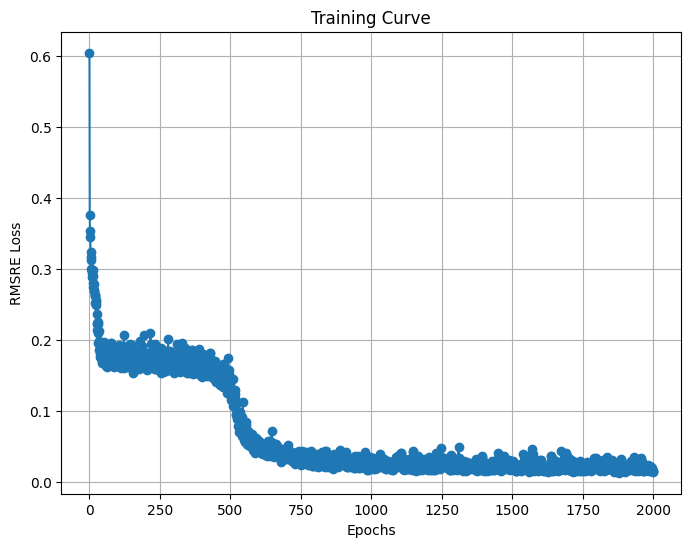

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Step 1: Define RMSRE Loss Function
class RMSRELoss(nn.Module):
    def __init__(self):
        super(RMSRELoss, self).__init__()

    def forward(self, predictions, targets):
        # Add epsilon to avoid division by zero
        epsilon = 1e-6
        relative_error = torch.log1p((predictions - targets).abs() / (targets.abs() + epsilon))
        return torch.sqrt(torch.mean(relative_error**2))

# Step 2: Define Multimodal Model
class MultimodalModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, joint_dim, output_dim):
        super(MultimodalModel, self).__init__()
        # Modality 1 Encoder
        self.modality1_encoder = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, joint_dim)
        )
        # Modality 2 Encoder
        self.modality2_encoder = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, joint_dim)
        )
        # Joint Prediction Layer
        self.joint_predictor = nn.Sequential(
            nn.Linear(joint_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # Split input into two modalities
        modality1, modality2 = torch.split(x, x.size(1) // 2, dim=1)
        # Encode each modality
        m1_embed = self.modality1_encoder(modality1)
        m2_embed = self.modality2_encoder(modality2)
        # Concatenate joint embedding
        joint_embedding = torch.cat([m1_embed, m2_embed], dim=1)
        # Predict target
        return self.joint_predictor(joint_embedding)

# Step 3: Model Training Function
def train_model(model, train_loader, criterion, optimizer, epochs=500):
    model.train()
    train_loss = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        for features, labels in train_loader:
            # Move data to device
            features, labels = features.to(device), labels.to(device)
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels.unsqueeze(1))
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        train_loss.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

    return train_loss

# Step 4: Visualize Training Curve
def plot_training_curve(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('RMSRE Loss')
    plt.title('Training Curve')
    plt.grid()
    plt.show()

# Step 5: Prepare Data and Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = train_loader.dataset.features.shape[1]
hidden_dim = 128
joint_dim = 64
output_dim = 1

# Initialize Model, Loss, and Optimizer
model = MultimodalModel(input_dim, hidden_dim, joint_dim, output_dim).to(device)
criterion = RMSRELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Step 6: Train the Model
epochs = 2000
losses = train_model(model, train_loader, criterion, optimizer, epochs=epochs)

# Step 7: Plot Training Curve
plot_training_curve(losses)

In [34]:
import pandas as pd
import torch

# Step 1: Predict on Test Data
def predict_on_test(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    predictions = []
    with torch.no_grad():
        for features in test_loader:
            features = features.to(device)
            outputs = model(features).squeeze(1)  # Remove extra dimension
            predictions.extend(outputs.cpu().numpy())
    return predictions

# Step 2: Generate Submission File
def generate_submission_file(predictions, output_path='submission.csv'):
    # Create a DataFrame in the required format
    submission = pd.DataFrame({
        'row_id': range(len(predictions)),  # Generate row IDs starting from 0
        'label': predictions  # Add predictions
    })
    submission.to_csv(output_path, index=False)
    print(f"Submission file saved to {output_path}")

# Step 3: Predict and Save Submission
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure model and test_loader are defined
# model: The trained model
# test_loader: DataLoader for test data
predictions = predict_on_test(model, test_loader, device)
generate_submission_file(predictions, output_path='submission.csv')

Submission file saved to submission.csv
